# Experiment Nine

## Processing

In [2]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
pd.options.mode.chained_assignment = None

### Reading Data and Defining Constants

Notice the first three entries of the `survey-eight-entries.json` are discarded since they were collected before the experiment went live. This can be seen from the fact that these are the only three entries without a `responseType` attribute. These were written to the database before this was added to the code.

In [3]:
FILE_NAMES = [
    'raw-data/survey-eight-entries.json',
    'raw-data/survey-nine-entries.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 7
GROUP_SIZE = NUM_QUESTIONS // 2

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)
master_responses = master_responses[3:]

### Reading Responses into Data

In [4]:
col_labels = processing.get_col_labels(NUM_QUESTIONS,
                                       NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [5]:
processing.fill_experiment_data(data, master_responses)

In [6]:
data = pd.DataFrame(data)
sample_size = len(data)
print(data.size, sample_size)
data.head()

145644 1374


,consent,group_number,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_j2,high_q0_j3,high_q0_j4,high_q0_j5,...,low_q4_j2,low_q4_j3,low_q4_j4,low_q4_j5,low_q4_j6,low_q4_score,participant_id,response_type,test_one,test_two
0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,99rekf2t4xdtu5odhzavjdvp9xuonxrj,1,NaN,NaN
1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,452qucx2hfd37w8xa6lqqaot87zse4os,1,NaN,NaN
2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bnl1pze39sr3r5tbqymy43wet88xcjcz,1,NaN,NaN
3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ot522v0x3kbbo1fdkksm99rsc21gvv9g,1,NaN,NaN
4,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,y28quqev3xut7s1s765onuyy775mq59v,1,NaN,NaN


In [7]:
view_data = data[data.response_type == 1]
response_data = data[data.response_type == 0]
response_data = response_data[response_data.consent == 1]

print(len(view_data), len(response_data))
print('{:.4}% completion'.format(len(response_data) / len(view_data) * 100))

774 600
77.52% completion


### Seperating Groups and Checking Response Rate

In [8]:
control_views = view_data[view_data.group_number == 0] 
post_views = view_data[view_data.group_number == 1]
upvote_views = view_data[view_data.group_number == 2]
control_responses = response_data[response_data.group_number == 0]
post_responses = response_data[response_data.group_number == 1]
upvote_responses = response_data[response_data.group_number == 2]

print(len(control_views), len(post_views), len(upvote_views))
print(len(control_responses), len(post_responses), len(upvote_responses))

186 197 391
138 161 301


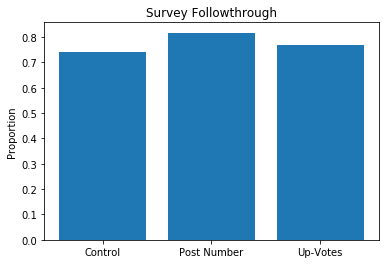

In [9]:
PLOTTING_OPTIONS = {
    'ylabel': 'Proportion',
    'ticks': ['Control', 'Post Number', 'Up-Votes'],
    'title': 'Survey Followthrough',
    
}

plotting.plot_single_bar(
    [len(control_responses) / len(control_views),
     len(post_responses) / len(post_views),
     len(upvote_responses) / len(upvote_views)],
    **PLOTTING_OPTIONS
)

### Checking Quiz Results

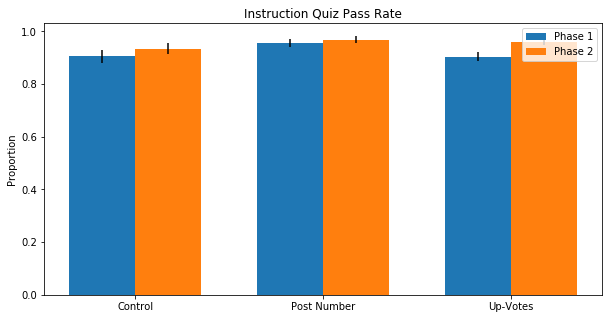

In [10]:
PLOTTING_OPTIONS = {
    'ylabel': 'Proportion',
    'ticks': ['Control', 'Post Number', 'Up-Votes'],
    'legend': ['Phase 1', 'Phase 2'],
    'title': 'Instruction Quiz Pass Rate',
    'size': (10, 5)
}

one_means, one_errs = [], []
two_means, two_errs = [], []
for group in (control_responses, post_responses, upvote_responses):
    one_means.append(group.test_one.mean())
    one_errs.append(stats.sem(group.test_one))
    two_means.append(group.test_two.mean())
    two_errs.append(stats.sem(group.test_two))
    
plotting.plot_double_bar(one_means, one_errs, two_means,
                         two_errs, **PLOTTING_OPTIONS)


In [11]:
new_control_responses = control_responses[
    (control_responses.test_one == 1) | (control_responses.test_two == 1)]
new_post_responses = post_responses[
    (post_responses.test_one == 1) | (post_responses.test_two == 1)]
new_upvote_responses = upvote_responses[
    (upvote_responses.test_one == 1) | (upvote_responses.test_two == 1)]

control_removed = len(control_responses) - len(new_control_responses)
post_removed = len(post_responses) - len(new_post_responses)
upvote_removed = len(upvote_responses) - len(new_upvote_responses)

print('Control: {} removed ({:.3}%) {} left'.format(
    control_removed,
    control_removed / len(control_responses) * 100,
    len(new_control_responses)
))
print('Post: {} removed ({:.3}%) {} left'.format(
    post_removed,
    post_removed / len(new_post_responses) * 100,
    len(new_post_responses)
))
print('Upvote: {} removed ({:.3}%) {} left'.format(
    upvote_removed,
    upvote_removed / len(new_upvote_responses) * 100,
    len(new_upvote_responses)
))

Control: 4 removed (2.9%) 134 left
Post: 0 removed (0.0%) 161 left
Upvote: 4 removed (1.35%) 297 left


### Naive Variance Analaysis

C:\Users\RACH0_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
C:\Users\RACH0_000\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\RACH0_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
C:\Users\RACH0_000\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2

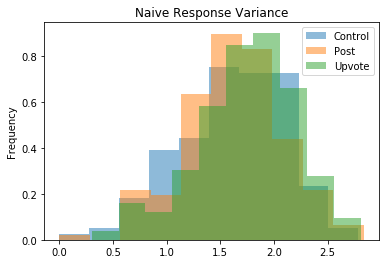

In [12]:
PLOTTING_OPTIONS = {
    'title': 'Naive Response Variance',
    'ylabel': 'Frequency',
    'legend': ['Control', 'Post', 'Upvote']
}

for data in (control_responses, post_responses, upvote_responses):
    all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                            q_label, j_label in itertools.product(
                                ALL_LABELS, JUDGMENT_LABELS)]
    data.total_var = data[all_judgment_headers].std(axis=1)
    plt.hist(data.total_var, alpha=0.5, normed=1)

plotting.label_graph(**PLOTTING_OPTIONS)
plt.show()

C:\Users\RACH0_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
C:\Users\RACH0_000\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\RACH0_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
C:\Users\RACH0_000\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2

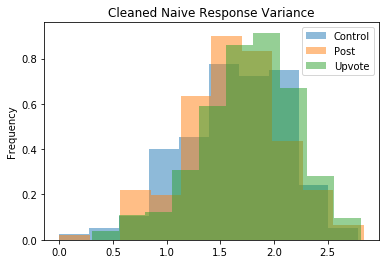

In [13]:
PLOTTING_OPTIONS = {
    'title': 'Cleaned Naive Response Variance',
    'ylabel': 'Frequency',
    'legend': ['Control', 'Post', 'Upvote']
}

for data in (new_control_responses, new_post_responses, new_upvote_responses):
    all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                            q_label, j_label in itertools.product(
                                ALL_LABELS, JUDGMENT_LABELS)]
    data.total_var = data[all_judgment_headers].std(axis=1)
    plt.hist(data.total_var, alpha=0.5, normed=1)

plotting.label_graph(**PLOTTING_OPTIONS)
plt.show()

In [ ]:
control_responses = new_control_responses
post_responses = new_post_responses
upvote_responses = new_upvote_responses

### Control Question Distribution

In [ ]:
COLUMN_NAMES = ['curiosity', 'confidence', 'usefulness',
    'popularity', 'writing', 'surprise', 'social_utility',
    'number', 'choice']
flattened_data = {col: [] for col in COLUMN_NAMES}

for index, row in control_responses.iterrows():
    for q_label in ALL_LABELS:
        for number, col_name in enumerate(COLUMN_NAMES[:-2]):
            flattened_data[col_name].append(
                row['{}_j{}'.format(q_label, number)])
    
        choice_info = row['{}_choice'.format(q_label)]
        index_info = row['{}_index'.format(q_label)]
        
        flattened_data['choice'].append(choice_info)
        flattened_data['number'].append(index_info)

In [ ]:
question_data = pd.DataFrame(flattened_data)
question_data.head()

In [ ]:
grouped = question_data.groupby(question_data.number)
distribution = grouped.choice.agg(np.mean)

first = stats.kstest(
((distribution
    - distribution.mean())
    / distribution.std()),
 'norm'
)
second = stats.shapiro(
((distribution
    - distribution.mean())
    / distribution.std()),
)
print(first, second)

### Saving Data

In [ ]:
control_responses.to_pickle('raw-data/control-responses.pkl')
post_responses.to_pickle('raw-data/post-responses.pkl')
upvote_responses.to_pickle('raw-data/upvote-responses.pkl')